# Multimapping analysis 
## Before running this notebook:
1. Ran `analysis2_multipmapping.sh` to generate lookup tables for all bam files 
2. Pick reads of interest: 
bed file: `data/full_intergenic.bed`
bam files:
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2.bam`
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam`
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate2_run1/SGNex_MCF7_Illumina_replicate2_run1.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate4_run1/SGNex_MCF7_Illumina_replicate4_run1.bam`
Focusing on 
- `longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam`
- `illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam`
Command: 
```
sed 's/^chr//' data/full_intergenic.bed > data/full_intergenic_no_chr.bed
bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam -b data/full_intergenic_no_chr.bed -bed | awk '{print $4}' > read_ids.txt


bedtools intersect -abam illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam -b data/full_intergenic_no_chr.bed -bed | awk '{print $4}' > illumina_files/SGNex_MCF7_Illumina_replicate3_run1/read_ids.txt
```

awk '{print $4}'
awk '{print substr($4, 1, length($4)-2)}'

In [ ]:
# What do I need to do:
# 1. Figure out if I can just use the first value in the lookup table (I think I can)
# 2. Figure out how to rerun the lookup table code so it just prints one copy of all of the reads

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from pathlib import Path

In [5]:
def open_files(lookup_table_path, read_ids_path, short=False):
    df = pd.read_csv(
        lookup_table_path,
        sep="\t",
        header=None,
    ).drop_duplicates(subset=0, keep="first")
    df.columns = ["read_id", "count"]

    # Read the file and store each line as an element in a list
    with open(read_ids_path, "r") as file:
        read_ids = file.readlines()
    if short:
        # remove
        read_ids = list(set([line.strip() for line in read_ids]))
    else:
        read_ids = list(set([line.strip() for line in read_ids]))
    return df, read_ids


def run_sims(df, read_ids, title, n_iterations=1000):
    l1hs_df = df[df["read_id"].isin(read_ids)]
    # Create a background distribution by random sampling
    sample_size = len(l1hs_df)
    background_distributions = []

    for _ in range(n_iterations):
        sample = df.sample(n=sample_size)
        background_distributions.append(len(sample[sample["count"] > 1]))

    count = len(l1hs_df[l1hs_df["count"] > 1])

    z_score = (count - np.mean(background_distributions)) / np.std(
        background_distributions
    )
    p_value = 1 - stats.norm.cdf(z_score)

    # Print the result
    print(
        f"Number of L1HS multi-mappingreads: {count}, Mean from background: {np.mean(background_distributions)}, STDEV: {np.std(background_distributions)} \nP-value: {p_value}"
    )

    # Plot the background distribution with the observed value
    fig, ax = plt.subplots()
    sns.histplot(background_distributions, ax=ax)
    ax.axvline(count, color="red")
    ax.set_title(title)
    ax.set_xlabel("Number of reads that are multi-mapping")
    ax.set_ylabel("Frequency")

    annotation_text = f"Observed count: {count}\nZ-score: {z_score:.2f}\nP-value < 0.001\nMean: {np.mean(background_distributions):.2f}\nSTDEV: {np.std(background_distributions):.2f}"
    # lower the annotation so it doesnt overlap with the gridlines

    ax.annotate(
        annotation_text,
        xy=(count, ax.get_ylim()[1]),
        xytext=(10, -30),
        textcoords="offset points",
        ha="left",
        va="top",
        fontsize=10,
        color="red",
        arrowprops=dict(facecolor="red", shrink=0.05),
    )

    plt.show()

Number of L1HS multi-mappingreads: 28, Mean from background: 6.029, STDEV: 2.4556382062510753 
P-value: 0.0


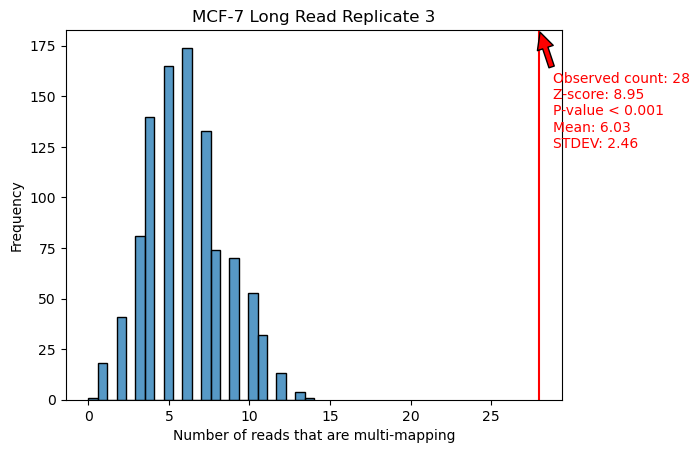

In [6]:
look_up_path = "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_lookup_table.txt"
read_ids_path = "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/reads_id.txt"

df_long, read_ids = open_files(look_up_path, read_ids_path)
run_sims(df_long, read_ids, "MCF-7 Long Read Replicate 3")

Number of L1HS multi-mappingreads: 826, Mean from background: 57.34, STDEV: 7.0967880058516615 
P-value: 0.0


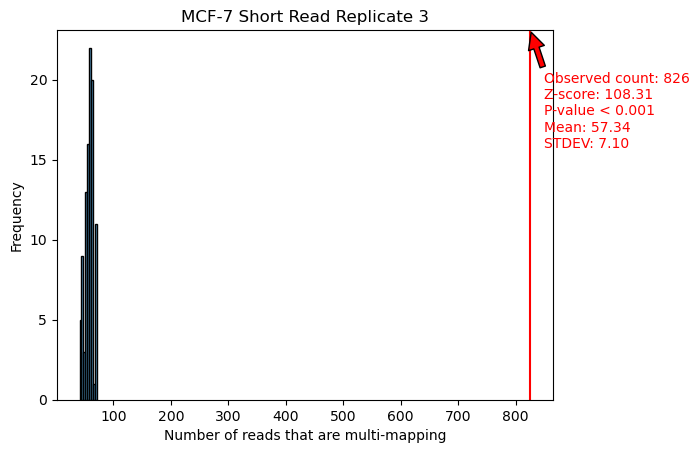

In [7]:
short_lookup = "illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1_lookup_table.txt"
short_readids = "illumina_files/SGNex_MCF7_Illumina_replicate3_run1/read_ids.txt"

df_short, read_ids = open_files(short_lookup, short_readids, True)
run_sims(df_short, read_ids, "MCF-7 Short Read Replicate 3", n_iterations=100)

<Axes: xlabel='read_type', ylabel='count'>

Error in callback <function _draw_all_if_interactive at 0x7f5bbf467d00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

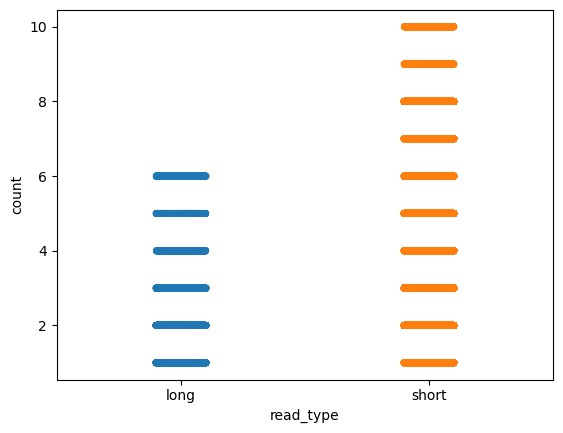

In [8]:
# merge df_long and df_short and add a column for which df they're from
df_long["read_type"] = "long"
df_short["read_type"] = "short"
df = pd.concat([df_long, df_short])
sns.stripplot(data=df, x="read_type", y="count")

In [17]:
# jitter plot with data from both replicates
fig, ax = plt.subplots()
sns.stripplot(data=df, x="count", jitter=0.2, ax=ax)

,read_id,count
0,00000a21-7076-4538-9613-da3bb8fa2c08,1
1,00000abb-0179-4fb6-a230-b33825cfbe63,1
2,00000c88-e142-4000-abc3-6c5a45a421b5,3
3,00000c88-e142-4000-abc3-6c5a45a421b5,2
4,00000c88-e142-4000-abc3-6c5a45a421b5,1
...,...,...
2951941,ffffda83-ecb1-4cca-ba75-38cda94984de,1
2951942,ffffda83-ecb1-4cca-ba75-38cda94984de,1
2951943,ffffda83-ecb1-4cca-ba75-38cda94984de,1
2951944,fffff58c-8f70-41bd-94c5-7813c8b0a368,1


In [18]:
len(df["read_id"])

2951946

In [60]:
with open(short_readids, "r") as file:
    read_ids = file.readlines()
read_ids = list(set([line.strip() for line in read_ids]))

In [61]:
read_ids

['K00151:464:H3HL2BBXY:2:1103:13443:11671/2',
 'K00151:464:H3HL2BBXY:3:2226:16985:17456/1',
 'K00151:464:H3HL2BBXY:2:1208:2301:8295/1',
 'K00151:464:H3HL2BBXY:3:2220:22790:26529/1',
 'K00151:464:H3HL2BBXY:3:1105:5792:28692/1',
 'K00151:464:H3HL2BBXY:3:1218:14783:22186/1',
 'K00151:464:H3HL2BBXY:2:1205:14397:25738/2',
 'K00151:464:H3HL2BBXY:2:2106:22587:25896/1',
 'K00151:464:H3HL2BBXY:2:1117:2808:1508/1',
 'K00151:464:H3HL2BBXY:2:2102:26007:6572/2',
 'K00151:464:H3HL2BBXY:3:2124:31649:4884/1',
 'K00151:464:H3HL2BBXY:2:1119:25093:31294/2',
 'K00151:464:H3HL2BBXY:3:2225:10774:29307/2',
 'K00151:464:H3HL2BBXY:3:2106:20334:29202/1',
 'K00151:464:H3HL2BBXY:3:2118:24231:44464/2',
 'K00151:464:H3HL2BBXY:3:2103:14387:4092/1',
 'K00151:464:H3HL2BBXY:2:1118:3508:18652/1',
 'K00151:464:H3HL2BBXY:2:1222:3072:23065/1',
 'K00151:464:H3HL2BBXY:2:1115:7547:43515/2',
 'K00151:464:H3HL2BBXY:3:2213:11525:34688/2',
 'K00151:464:H3HL2BBXY:2:1210:23510:16102/1',
 'K00151:464:H3HL2BBXY:3:2216:26808:30855/2',

In [49]:
l1hs_df = df[df["read_id"].isin(read_ids)]
# Create a background distribution by random sampling
sample_size = len(l1hs_df)
background_distributions = []

for _ in range(100):
    sample = df.sample(n=sample_size)
    background_distributions.append(len(sample[sample["count"] > 1]))

count = len(l1hs_df[l1hs_df["count"] > 1])

z_score = (count - np.mean(background_distributions)) / np.std(background_distributions)
p_value = 1 - stats.norm.cdf(z_score)

# Print the result
print(
    f"Number of L1HS multi-mappingreads: {count}, Mean from background: {np.mean(background_distributions)}, STDEV: {np.std(background_distributions)} \nP-value: {p_value}"
)

Number of L1HS multi-mappingreads: 1482, Mean from background: 1482.0, STDEV: 0.0 
P-value: nan


/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_21711/4060561111.py:12: RuntimeWarning: invalid value encountered in double_scalars
  z_score = (count - np.mean(background_distributions)) / np.std(background_distributions)


In [59]:
with open(read_ids_path, "r") as file:
    read_ids = file.readlines()

list(set([line.strip() for line in read_ids]))

['72f2259d-c775-4680-b0eb-494bfc44191a',
 '4a2025bb-c967-4144-b2ab-8c6090542cd2',
 '87994fc0-ef14-4291-8ccc-20d3dc4c4b16',
 'c20fddf5-531f-4dc3-aca2-ce44cfe82eb8',
 'ccebec80-98ac-4dd5-bae2-6698de100e9a',
 '79b4aae2-49d7-499e-a649-526a761d429d',
 'f4eabbc0-a9da-40ae-bd6b-98acbc52128d',
 'e3e41365-e74f-4a6f-8e45-f6c947ce3ea0',
 'c1267df2-4bf7-4c03-a3d9-33c3ff680130',
 '8dc6a163-c543-4a68-aeb3-865aa5b586a5',
 '5e8498c1-c0e0-4ded-a14b-64e104c6bdba',
 '03b4958a-9575-458a-b920-33b66336b400',
 '105cabae-c1be-4111-907a-e1059da55c25',
 'e8a18879-c4f5-4a38-bbde-9e3731c4ed70',
 '91327d21-b436-4c45-908f-5c07019e9d89',
 '0c7a41be-e922-4d30-8c52-2e6328c7ed44',
 '5afaf869-0fb9-4255-907f-b0126b1d0d0f',
 '91e934bd-eee7-435e-9917-8b0720b85296',
 'e90d3c48-3a96-41a2-ac5d-8cd215e369ab',
 'c01190f2-a7f3-4d21-87f0-ea93d1893b2a',
 '81102e72-858f-49ba-9b93-2bbba733b0a1',
 'da2d78eb-9baa-471d-86e3-50d9812cec49',
 '74f1e848-041e-48a2-986c-9c3d5fdea074',
 'ec30c01b-7a75-4f08-ae7d-5fa961fabac2',
 '62983670-c501-

In [51]:
l1hs_df["count"].value_counts()

2     608
4     300
6     163
8     118
10     92
12     59
14     55
16     37
18     31
20     16
22      2
32      1
Name: count, dtype: int64

In [54]:
df["count"].value_counts().sort_index()

2     27113249
4      2145255
6       443818
8       118646
10      119981
12       31539
14      147017
16      374621
18       66662
20       23670
22        8209
24        2874
26        1268
28         756
30         947
32        1244
34         650
36         307
38         146
40          66
42          23
44          14
46           9
48          10
50          10
52           4
54           5
56           1
58           1
62           1
64           1
Name: count, dtype: int64

In [ ]:
# Plot the background distribution with the observed value
fig, ax = plt.subplots()
sns.histplot(background_distributions, ax=ax)
ax.axvline(count, color="red")
ax.set_title("title")
ax.set_xlabel("Number of reads mapping to L1HS")
ax.set_ylabel("Frequency")

## Multimapping and Unique Read Distribution Analysis 

In [2]:
"""
For loci type s (F1F2,F1S1,F1S2,F2S1,F2S2,S1S2): 

1. extract read IDs and alignment score 
    1. read in corresponding bed file
    2. get all read_ids
    3. get top score from sorted tsv
    4. dictionary - read_id: alignment score
2. get all loci for read ids
    1. for all bed files 
        1. for readname in bed file
            1. if readname is in all read_ids
                1. Add 1 count to dictionary 
                2. dictionary {sample: # of reads} 
        2. if bedfile is file s 
            1. drop non-duplicates lines
                1. count # of non duplicates
"""

'\nFor loci type s (F1F2,F1S1,F1S2,F2S1,F2S2,S1S2): \n\n1. extract read IDs and alignment score \n    1. read in corresponding bed file\n    2. get all read_ids\n    3. get top score from sorted tsv\n    4. dictionary - read_id: alignment score\n2. get all loci for read ids\n    1. for all bed files \n        1. for readname in bed file\n            1. if readname is in all read_ids\n                1. Add 1 count to dictionary \n                2. dictionary {sample: # of reads} \n        2. if bedfile is file s \n            1. drop non-duplicates lines\n                1. count # of non duplicates\n'

In [19]:
def make_barplots(base_path):
    samples = [
        "full_intergenic_AS",
        "full_intronic_AS",
        "truncate_intergenic_AS",
        "truncate_intronic_AS",
    ]
    read_counts = {sample: [] for sample in samples}
    for sample in samples:
        if Path(f"{base_path}/{sample}.bed").stat().st_size == 0:
            # append zero to all samples
            [read_counts[sample].append(0) for sample in samples]
            continue

        bed_df = pd.read_csv(f"{base_path}/{sample}.bed", sep="\t", header=None)
        read_ids = bed_df[3].unique()
        for bed_file_prefix in samples:
            # if file is empty then skip
            if Path(f"{base_path}/{bed_file_prefix}.bed").stat().st_size == 0:
                read_counts[bed_file_prefix].append(0)
                continue

            bed_df = pd.read_csv(
                f"{base_path}/{bed_file_prefix}.bed", sep="\t", header=None
            )
            if sample == bed_file_prefix:
                # drop unique lines
                bed_df = bed_df[bed_df.duplicated(subset=3, keep=False)]
                # get number of non-duplicates
                read_counts[bed_file_prefix].append(
                    len(bed_df) - len(bed_df.drop_duplicates(subset=3))
                )
                continue
            read_counts[bed_file_prefix].append(len(bed_df[bed_df[3].isin(read_ids)]))

    # Transforming data to the desired format for plotting
    df = pd.DataFrame(read_counts)
    # Transposing the DataFrame to get categories on the x-axis and values stacked
    df = df.T
    df.columns = samples

    # Plotting
    fig, ax = plt.subplots()
    df.plot(kind="bar", stacked=True, ax=ax)

    # Setting titles and labels
    ax.set_xlabel("Categories")
    ax.set_ylabel("Number of reads")
    ax.set_title(f"{base_path} Read Counts For Different Loci Categories")
    plt.xticks(rotation=45)

    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

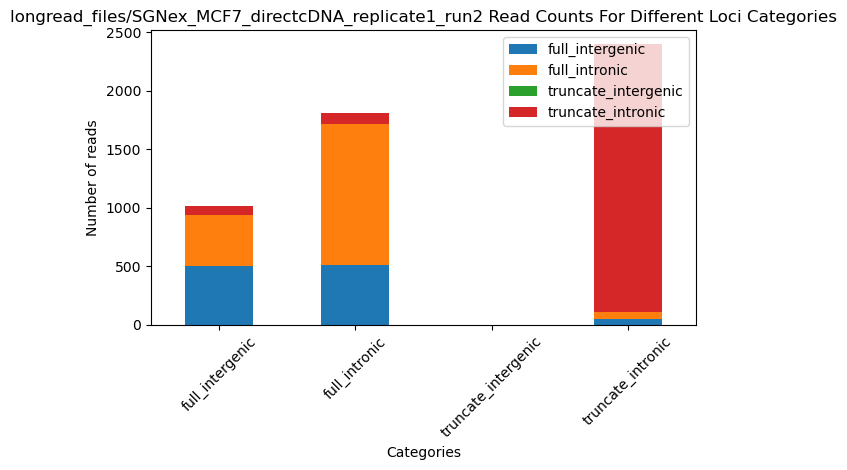

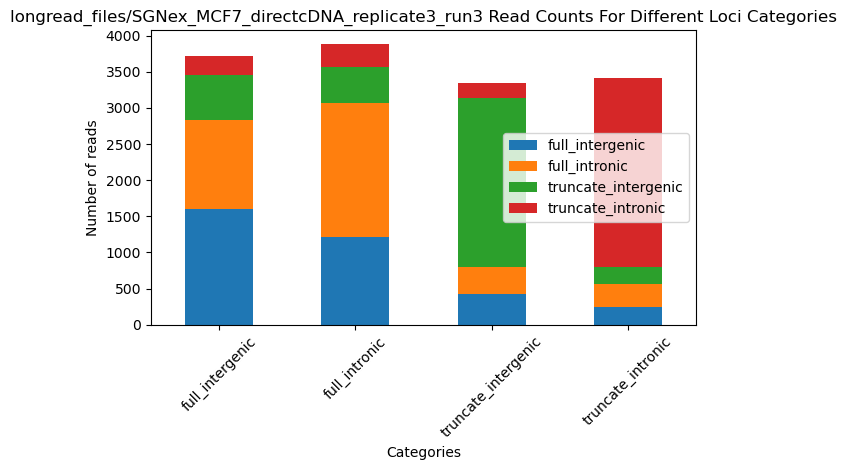

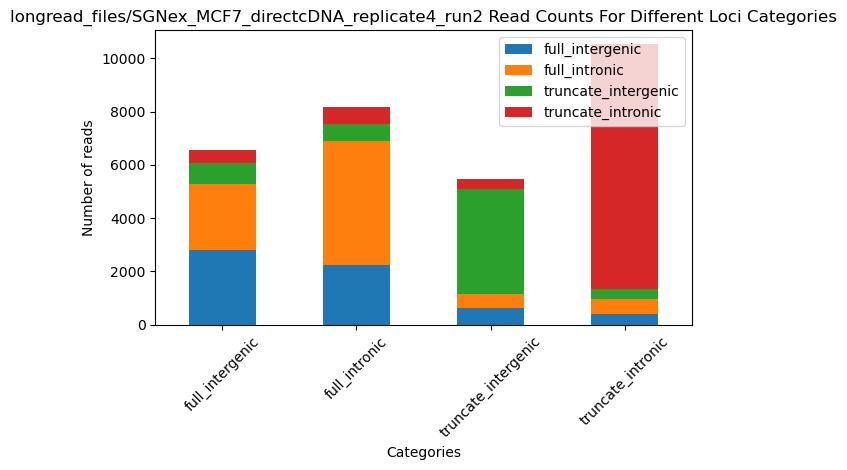

In [21]:
basepaths = [
    "longread_files/SGNex_MCF7_directcDNA_replicate1_run2",
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3",
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2",
]

for path in basepaths:
    make_barplots(path)

## This is the first version where it is NOT just highest alignment scores

```
bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam -b data/full_intergenic_no_chr.bed -bed > longread_files/SGNex_MCF7_directcDNA_replicate4_run2/full_intergenic_AS.bed

bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam -b data/full_intergenic_no_chr.bed -bed > longread_files/SGNex_MCF7_directcDNA_replicate4_run2/full_intergenic_AS.bed

bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam -b data/full_intergenic_no_chr.bed -bed > longread_files/SGNex_MCF7_directcDNA_replicate4_run2/full_intergenic_AS.bed

bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam -b data/full_intergenic_no_chr.bed -bed > longread_files/SGNex_MCF7_directcDNA_replicate4_run2/full_intergenic_AS.bed
```

In [27]:
import pysam
import subprocess


def run_bedtools_intersect(file_path):

    prefix = "/".join(file_path.split("/")[:-1])
    for bed_file in [
        "full_intergenic_no_chr.bed",
        "full_intronic_no_chr.bed",
        "truncate_intergenic_no_chr.bed",
        "truncate_intronic_no_chr.bed",
    ]:
        cmd = [
            "bedtools",
            "intersect",
            "-abam",
            file_path,
            "-b",
            "data/" + bed_file,
            "-bed",
        ]
        output_file = f"{prefix}/{'_'.join(bed_file.split('_')[:2])}_AS.bed"

        with open(output_file, "w") as outfile:
            subprocess.run(cmd, stdout=outfile)


def process_bams(bam_file):

    # get top alignment score
    sorted_tsv = bam_file.split(".")[0] + ".sorted.tsv"
    df = pd.read_csv(
        sorted_tsv,
        sep="\t",
        header=None,
    )

    # iterate through df rows
    # for each new value in col 0, save the first value in col 1
    # save the read_id and alignment score in a dictionary

    read_scores = {}
    for row in df.itertuples():
        if row[1] not in read_scores:
            read_scores[row[1]] = row[2]

    # Open the input and output BAM files
    input_bam = pysam.AlignmentFile(bam_file, "rb")
    output_bam = pysam.AlignmentFile(bam_file + "_TOP_AS.bam", "wb", template=input_bam)

    for read in input_bam:
        # if AS tag is not present then skip
        if read.has_tag("AS"):
            # if read is multimapped then skip
            if read_scores[read.query_name] == read.get_tag("AS"):
                output_bam.write(read)

    input_bam.close()
    output_bam.close()

    run_bedtools_intersect(bam_file + "_TOP_AS.bam")

In [28]:
run_bedtools_intersect(
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam"
)

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-



***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replica

In [30]:
run_bedtools_intersect(
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam"
)

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam has inconsistent naming convention for record:
chrIS	30008	96458	72ccb87b-ee09-443a-81f9-f75f2c84553d	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam has inconsistent naming convention for record:
chrIS	30008	96458	72ccb87b-ee09-443a-81f9-f75f2c84553d	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam has inconsistent naming convention for record:
chrIS	30008	96458	72ccb87b-ee09-443a-81f9-f75f2c84553d	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam has inconsistent naming convention for record:
chrIS	30008	96458	72ccb87b-ee09-443a-81f9-f75f2c84553d	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_M

In [33]:
run_bedtools_intersect(
    "longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2.bam_TOP_AS.bam"
)

In [ ]:
"""bampaths = ['longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam',
			'longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2.bam',
			'longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2.bam']
			
for path in bampaths: 
	process_bams(path)"""

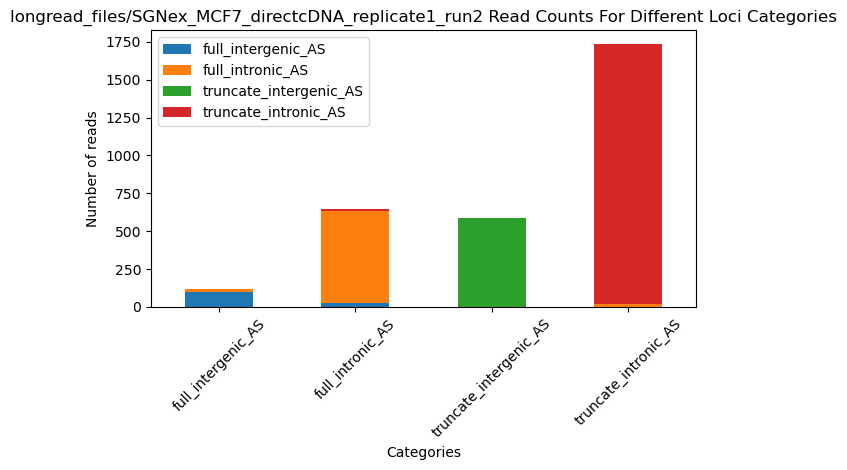

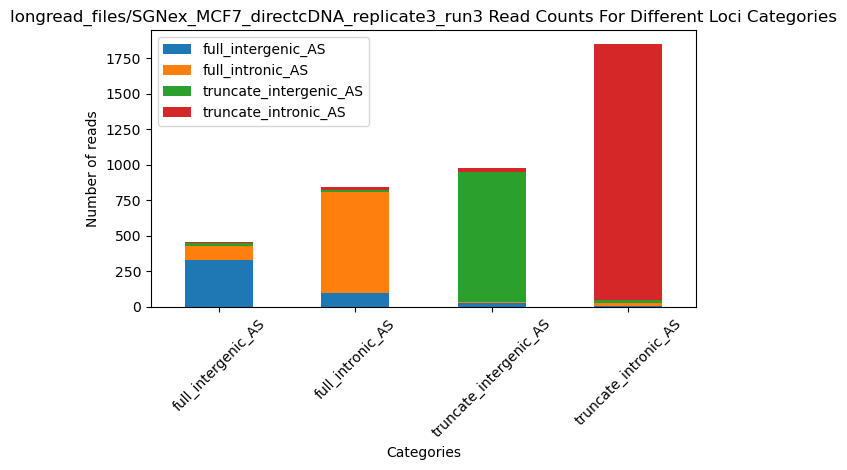

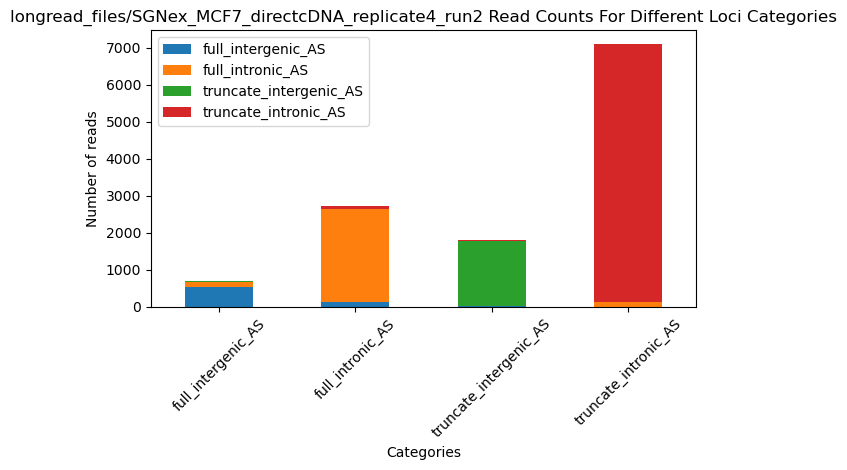

In [34]:
basepaths = [
    "longread_files/SGNex_MCF7_directcDNA_replicate1_run2",
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3",
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2",
]

for path in basepaths:
    make_barplots(path)

# Upset plot

In [3]:
from upsetplot import UpSet
from matplotlib import pyplot
import pandas as pd
from pathlib import Path
import pysam
import numpy as np

In [12]:
def read_data(base_path):
    samples = [
        "full_intergenic_AS",
        "full_intronic_AS",
        "truncate_intergenic_AS",
        "truncate_intronic_AS",
    ]

    master_read_info = {}
    individual_read_info = {
        sample: 0 for sample in samples + [sample2 + "_unique" for sample2 in samples]
    }

    ids = {}
    # get list of read_ids for each sample
    for sample in samples:
        if Path(f"{base_path}/{sample}.bed").stat().st_size == 0:
            # append zero to all samples
            ids[sample] = set()
            continue
        bed_df = pd.read_csv(f"{base_path}/{sample}.bed", sep="\t", header=None)
        read_ids = bed_df[3].unique()
        ids[sample] = set(read_ids)

    # iterate through reads in bam file
    bam_file = f"{base_path}/{base_path.split('/')[-1]}.bam"
    input_bam = pysam.AlignmentFile(bam_file, "rb")

    for read in input_bam:
        # if AS tag is not present then skip
        if read.has_tag("AS"):
            # get read_id
            read_id = read.query_name
            master_read_info[read_id] = individual_read_info.copy()
            # if read exists in any of the ids categorys, add 1 to the count
            for k, v in ids.items():
                if read_id in v:
                    master_read_info[read_id][k] += 1
            # if read is unique to any of the ids categorys, add 1 to the count

    """	for bed_file_prefix in samples:
			# if file is empty then skip
			if Path(f"{base_path}/{bed_file_prefix}.bed").stat().st_size == 0:
				read_counts[bed_file_prefix].append(0)
				continue
			
			bed_df = pd.read_csv(f"{base_path}/{bed_file_prefix}.bed", sep="\t", header=None)
			if sample == bed_file_prefix:
				# drop unique lines
				bed_df = bed_df[bed_df.duplicated(subset=3,keep=False)]
				# get number of non-duplicates
				read_counts[bed_file_prefix].append(len(bed_df) - len(bed_df.drop_duplicates(subset=3)))
				continue
			read_counts[bed_file_prefix].append(len(bed_df[bed_df[3].isin(read_ids)]))

	# Transforming data to the desired format for plotting
	df = pd.DataFrame(read_counts)
	# Transposing the DataFrame to get categories on the x-axis and values stacked
	df = df.T
	df.columns = samples"""

    return df

In [13]:
path = "longread_files/SGNex_MCF7_directcDNA_replicate4_run2"
df = make_barplots(path)
df.head()

,full_intergenic_AS,full_intronic_AS,truncate_intergenic_AS,truncate_intronic_AS
full_intergenic_AS,541,129,27,9
full_intronic_AS,141,2501,0,93
truncate_intergenic_AS,33,0,1749,21
truncate_intronic_AS,9,114,21,6976


In [ ]:
basepaths = [
    "longread_files/SGNex_MCF7_directcDNA_replicate1_run2",
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3",
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2",
]

for path in basepaths:
    make_barplots(path)

In [ ]:
# 4 categories + 4 categories_unique

# get read_ids for category
# look at the intersection of read_ids for each category

In [57]:
def transform_series(series):
    # Convert the MultiIndex series into a DataFrame
    df = series.reset_index(name="count")

    # Identify unique categories from the MultiIndex
    categories = pd.unique(df.drop(columns="count").values.ravel("K"))

    # Initialize a dictionary to hold our transformed data
    transformed_data = {category: [] for category in categories}
    transformed_data["count"] = []

    # Populate the dictionary with True/False for the presence of each category
    for index, row in df.iterrows():
        for category in categories:
            transformed_data[category].append(category in row.values)
        transformed_data["count"].append(row["count"])

    # Convert the dictionary back into a DataFrame
    transformed_df = pd.DataFrame(transformed_data)

    # Reorder the DataFrame to have 'count' as the last column
    cols = list(transformed_df.columns)
    cols.remove("count")
    cols.append("count")
    transformed_df = transformed_df[cols]

    return transformed_df


def read_data(base_path):
    samples = [
        "full_intergenic_AS",
        "full_intronic_AS",
        "truncate_intergenic_AS",
        "truncate_intronic_AS",
    ]

    ids = {}
    # get list of read_ids for each sample
    for sample in samples:
        if Path(f"{base_path}/{sample}.bed").stat().st_size == 0:
            # append zero to all samples
            ids[sample] = []
            continue
        bed_df = pd.read_csv(f"{base_path}/{sample}.bed", sep="\t", header=None)
        read_ids = list(bed_df[3])
        ids[sample] = read_ids

    # get all reads from every list in the dictionary and take its set
    all_reads = set([item for sublist in ids.values() for item in sublist])
    # Create a DataFrame indicating whether a read ID is in each category
    df = pd.DataFrame(index=list(all_reads), columns=samples)

    # Populate the DataFrame
    for sample in samples:
        df[sample] = df.index.isin(ids[sample])

    df["membership"] = df.apply(
        lambda row: ",".join(
            ["".join(col.split("_")[:2]) for col in df.columns if row[col]]
        ),
        axis=1,
    )

    # Count the number of occurrences of each membership combination
    membership_counts = df["membership"].value_counts()

    # Convert counts to a Series with a MultiIndex required by upsetplot
    index = pd.MultiIndex.from_tuples(
        [tuple(x.split(",")) for x in membership_counts.index]
    )
    upset_data = transform_series(pd.Series(membership_counts.values, index=index))

    return upset_data
    # Create and plot the UpSet plot
    upset = UpSet(upset_data)
    upset.plot()
    plt.show()

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

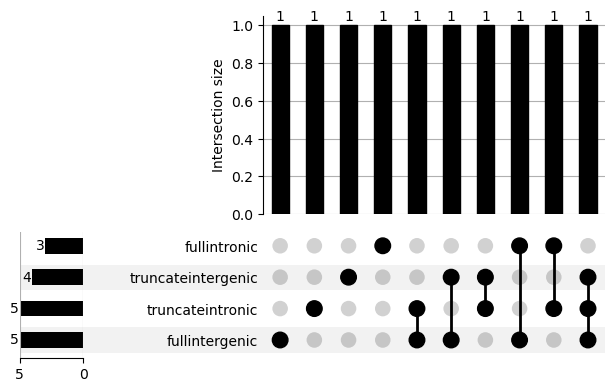

In [64]:
samples = ["fullintergenic", "fullintronic", "truncateintergenic", "truncateintronic"]

path = "longread_files/SGNex_MCF7_directcDNA_replicate4_run2"
data = read_data(path)
us = (
    data.reset_index()
    .drop(columns=[np.nan])
    .set_index(samples)
    .rename(columns={"count": "value"})
)
UpSet(us, sum_over="index", subset_size="sum", show_counts=True).plot()

In [61]:
us

index  value
fullintergenic fullintronic truncateintergenic truncateintronic              
False          False        False              True                  0   2556
               True         False              False                 1    933
               False        True               False                 2    456
True           False        False              False                 3    193
               True         False              False                 4     39
False          True         False              True                  5     31
True           False        True               False                 6      7
False          False        True               True                  7      4
True           False        False              True                  8      2
                            True               True                  9      1

In [51]:
us = (
    data.reset_index()
    .drop(columns=[np.nan])
    .set_index(samples)
    .rename(columns={"count": "value"})
)
us

index  value
fullintergenic fullintronic truncateintergenic truncateintronic              
False          False        False              True                  0   2556
               True         False              False                 1    933
               False        True               False                 2    456
True           False        False              False                 3    193
               True         False              False                 4     39
False          True         False              True                  5     31
True           False        True               False                 6      7
False          False        True               True                  7      4
True           False        False              True                  8      2
                            True               True                  9      1

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

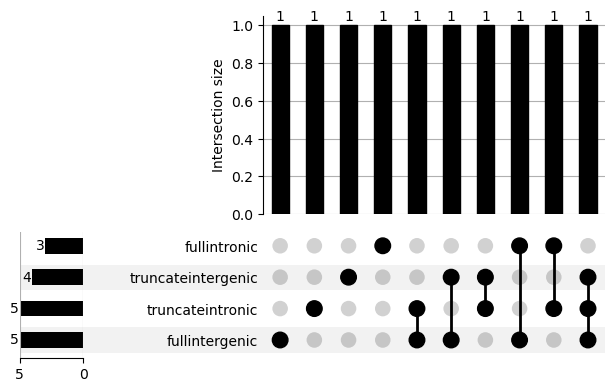

In [56]:
UpSet(us, show_counts=True).plot()